In [1]:
PATH = '/Users/siddhantthakur/pizza req/'

import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)

In [2]:
# certificate verification fail

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
with open(PATH + 'pizza_request_dataset/pizza_request_dataset.json', 'r') as f:
    data = json.load(f)

In [5]:
len(data)

5671

In [6]:
sorted(data[0].keys())

['giver_username_if_known',
 'in_test_set',
 'number_of_downvotes_of_request_at_retrieval',
 'number_of_upvotes_of_request_at_retrieval',
 'post_was_edited',
 'request_id',
 'request_number_of_comments_at_retrieval',
 'request_text',
 'request_text_edit_aware',
 'request_title',
 'requester_account_age_in_days_at_request',
 'requester_account_age_in_days_at_retrieval',
 'requester_days_since_first_post_on_raop_at_request',
 'requester_days_since_first_post_on_raop_at_retrieval',
 'requester_number_of_comments_at_request',
 'requester_number_of_comments_at_retrieval',
 'requester_number_of_comments_in_raop_at_request',
 'requester_number_of_comments_in_raop_at_retrieval',
 'requester_number_of_posts_at_request',
 'requester_number_of_posts_at_retrieval',
 'requester_number_of_posts_on_raop_at_request',
 'requester_number_of_posts_on_raop_at_retrieval',
 'requester_number_of_subreddits_at_request',
 'requester_received_pizza',
 'requester_subreddits_at_request',
 'requester_upvotes_minus

In [7]:
success = [d['requester_received_pizza'] for d in data]
print("Average Success Rate",str(sum(success)/len(success)*100))

Average Success Rate 24.634103332745546


In [8]:
for d in data:
    d['upvotes_minus_downvotes'] = d['number_of_upvotes_of_request_at_retrieval'] - d['number_of_downvotes_of_request_at_retrieval']

for d in data:
    d['final_request_text'] = d['request_title'] + " " + d['request_text_edit_aware']

In [9]:
data[0]

{'giver_username_if_known': 'N/A',
 'in_test_set': False,
 'number_of_downvotes_of_request_at_retrieval': 2,
 'number_of_upvotes_of_request_at_retrieval': 6,
 'post_was_edited': False,
 'request_id': 't3_w5491',
 'request_number_of_comments_at_retrieval': 7,
 'request_text': "I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine then.. It's just really painful at this point and food is something I'm constantly thinking about.\n\nI've got a few bucks to get on the bus to work on Saturday, so I can't really use that.\n\nI'm really embarrassed to even be asking like this and I'm not sure how it works, so please be patient with me.\n\nI guess tha

In [10]:
df = pd.json_normalize(data)
df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,upvotes_minus_downvotes,final_request_text
0,N/A,False,1,2,False,t3_xdtyq,1,Tomorrow I have a pretty stressful day ahead o...,Tomorrow I have a pretty stressful day ahead o...,[REQUEST] Dallas TX: Super Stressful Day,...,2384,5429,4068,8561,None,proFRESHional,1.343642e+09,1.343639e+09,1,[REQUEST] Dallas TX: Super Stressful Day Tomor...
1,N/A,False,4,10,False,t3_iaeiq,7,[This posting](http://www.reddit.com/r/Frugal/...,[This posting](http://www.reddit.com/r/Frugal/...,[REQUEST] Pizza for /r/frugal redditor katehaw...,...,819,36514,1189,72756,None,DodongoDislikesSmoke,1.309193e+09,1.309189e+09,6,[REQUEST] Pizza for /r/frugal redditor katehaw...
2,N/A,True,5,13,False,t3_1jd4uk,8,Hello. This is my first time on this subreddit...,Hello. This is my first time on this subreddit...,[Request] Would enjoy some pizza. Have nothing...,...,17042,23171,66866,79055,shroom,stormclaw11,1.375212e+09,1.375209e+09,8,[Request] Would enjoy some pizza. Have nothing...
3,N/A,False,1,1,False,t3_1l7avh,0,I'm in my freshman year of college. I moved ou...,I'm in my freshman year of college. I moved ou...,[Request] Jobless college kid wants some pizza,...,2804,3058,4246,4794,None,Bearjewbacca,1.377631e+09,1.377627e+09,0,[Request] Jobless college kid wants some pizza...
4,N/A,False,2,2,1363299991.0,t3_1ab9wo,4,(Tennessee USA) It is a day to celebrate after...,(Tennessee USA) It is a day to celebrate after...,[Request] US Married couple in between jobs wo...,...,521,555,865,921,shroom,lexifus,1.363303e+09,1.363300e+09,0,[Request] US Married couple in between jobs wo...


In [11]:
df['requester_received_pizza'].isna().sum()

0

In [12]:
# text preprocessing
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.replace("\n"," ").replace("\r"," ")
    text = re.sub(r'“', " '' ", text)
    text = re.sub(r'”', " '' ", text)
    text = re.sub(r'"', " '' ", text)
    text = re.sub(r'(\S)(\'\')', r'\1 \2 ', text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    punc_list = '!"#$%()*+,-./:;<=>?@^_{|}~[]'
    t = str.maketrans(dict.fromkeys(punc_list," "))
    text = text.translate(t)
    
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    
    text = text.lower()
    
    tokens = regexp_tokenize(text,pattern='\s+',gaps=True)
    cleaned_tokens = []
    
    for t in tokens:
        if t not in stopwords_eng:
            l = lemmatizer.lemmatize(t)
            cleaned_tokens.append(l)
    
    return cleaned_tokens

In [13]:
process_text(df['final_request_text'][0])

['request',
 'dallas',
 'tx',
 'super',
 'stressful',
 'day',
 'tomorrow',
 'pretty',
 'stressful',
 'day',
 'ahead',
 'got',
 'ton',
 'calling',
 'mailing',
 'application',
 'filling',
 'order',
 'drop',
 'one',
 'school',
 'enroll',
 'another',
 'pretty',
 'terrible',
 'handling',
 'stress',
 'pizza',
 'would',
 'perfect',
 'way',
 'unwind',
 'big',
 '3',
 'would',
 'fine',
 'pizza',
 'hut',
 'favorite']

In [14]:
text_data = df[['final_request_text','requester_received_pizza']]
text_data.head(10)

,final_request_text,requester_received_pizza
0,[REQUEST] Dallas TX: Super Stressful Day Tomor...,0
1,[REQUEST] Pizza for /r/frugal redditor katehaw...,0
2,[Request] Would enjoy some pizza. Have nothing...,1
3,[Request] Jobless college kid wants some pizza...,0
4,[Request] US Married couple in between jobs wo...,1
5,[REQUEST] Long story short... I'm hungry.\n\nA...,0
6,[Request] Home from work and tired in Henderso...,0
7,[REQUEST] Moving Military Redditor around McMi...,0
8,[Request] Putting a request in for a hungry fr...,0
9,[Request] The picture enclosed speaks for itse...,1


In [15]:
count_vec = CountVectorizer(analyzer = process_text)
count_df = count_vec.fit_transform(text_data['final_request_text'])
count_labels = text_data['requester_received_pizza']

print(count_df.shape)

# count_df vs count_labels [different models]

(5671, 14297)


In [16]:
count_df[0].shape

(1, 14297)

In [17]:
count_model = LogisticRegressionCV(cv = 5, random_state = 0).fit(count_df, count_labels)
print(count_model.predict_proba(count_df)[:20][:,1])
print(count_labels[:20])

[0.24276252 0.2494451  0.23911258 0.23784173 0.2431374  0.22921651
 0.23809087 0.26303427 0.23769644 0.23736114 0.24856683 0.23239975
 0.23116377 0.24472098 0.23483663 0.23842863 0.26410833 0.23976182
 0.25154147 0.24783341]
0     0
1     0
2     1
3     0
4     1
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    0
Name: requester_received_pizza, dtype: int64


In [18]:
tfidf_vec = TfidfVectorizer(analyzer = process_text)
tfidf_df = tfidf_vec.fit_transform(text_data['final_request_text'])
tfidf_labels = text_data['requester_received_pizza']

print(tfidf_df.shape)

# tfidf_df vs tfidf_labels [different models]

(5671, 14297)


In [19]:
tfidf_df[0].shape

(1, 14297)

In [20]:
tfidf_model = LogisticRegressionCV(cv = 5, random_state = 0).fit(tfidf_df, tfidf_labels)
print(tfidf_model.predict_proba(tfidf_df)[:20][:,1])
print(tfidf_labels[:20])

[0.23053032 0.29220888 0.20560304 0.1620422  0.32422858 0.15605429
 0.19482602 0.33554699 0.16594349 0.25240575 0.26047564 0.25225903
 0.13439624 0.25918898 0.21964048 0.20973629 0.38936879 0.25422266
 0.29111342 0.24631789]
0     0
1     0
2     1
3     0
4     1
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    0
Name: requester_received_pizza, dtype: int64


In [21]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [22]:
sen_emb = sbert_model.encode(text_data['final_request_text'])

In [23]:
sen_emb.shape

(5671, 768)

In [24]:
sen_labels = text_data['requester_received_pizza']

In [25]:
sen2vec_model = LogisticRegressionCV(cv = 5, random_state = 0).fit(sen_emb, sen_labels)
print(sen2vec_model.predict_proba(sen_emb)[:20][:,1])
print(sen_labels[:20])

[0.24804194 0.2516833  0.20742001 0.12464743 0.23694377 0.07073194
 0.21759187 0.33891045 0.13239403 0.21695439 0.29797116 0.08842239
 0.19385239 0.23497154 0.20264666 0.31392705 0.37917946 0.24163655
 0.30310071 0.20466738]
0     0
1     0
2     1
3     0
4     1
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    0
Name: requester_received_pizza, dtype: int64


In [26]:
est_proba = sen2vec_model.predict_proba(sen_emb)[:,1]

In [27]:
df.columns

Index(['giver_username_if_known', 'in_test_set',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_

In [28]:
final_model_df = df.loc[:,['upvotes_minus_downvotes','requester_account_age_in_days_at_request','request_number_of_comments_at_retrieval']]
final_model_df['length_of_text'] = df.apply(lambda r: len(r['final_request_text']), axis = 1)
final_model_df['prob_from_text'] = est_proba
final_model_df['evidence_link'] = df.apply(lambda r: 1 if re.findall(r'(?:http\:|https\:)?\/\/.*\.',r['final_request_text']) else 0, axis = 1)
final_model_df['requester_received_pizza'] = df.loc[:,'requester_received_pizza']
final_model_df = final_model_df.sample(frac=1).reset_index(drop=True)

final_model_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,prob_from_text,evidence_link,requester_received_pizza
0,1,282.986250,0,100,0.106224,0,0
1,0,0.000000,2,452,0.393631,0,1
2,3,216.770104,9,2192,0.346171,0,1
3,-1,110.601157,0,111,0.086089,0,0
4,2,20.112870,0,983,0.235983,0,0
...,...,...,...,...,...,...,...
5666,4,0.000000,0,297,0.289006,0,0
5667,0,0.000000,1,932,0.419425,0,0
5668,0,116.267014,0,663,0.350244,0,0
5669,7,522.532500,0,185,0.208544,0,0


In [29]:
final_model_df[final_model_df['evidence_link']==1]['requester_received_pizza'].value_counts()

0    256
1    141
Name: requester_received_pizza, dtype: int64

In [30]:
x = final_model_df.loc[:,final_model_df.columns != 'requester_received_pizza']
y = final_model_df['requester_received_pizza']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4536, 6)
(4536,)
(1135, 6)
(1135,)


In [32]:
final_model = LogisticRegressionCV(cv=5, random_state=0)
final_model.fit(x_train,y_train)
final_model.score(x_test,y_test)

0.7647577092511013

In [33]:
l = x_train.columns.values.tolist()
l

['upvotes_minus_downvotes',
 'requester_account_age_in_days_at_request',
 'request_number_of_comments_at_retrieval',
 'length_of_text',
 'prob_from_text',
 'evidence_link']

[-0.00661389  0.00060329  0.14702238  0.000159    5.58018197  0.28092484]


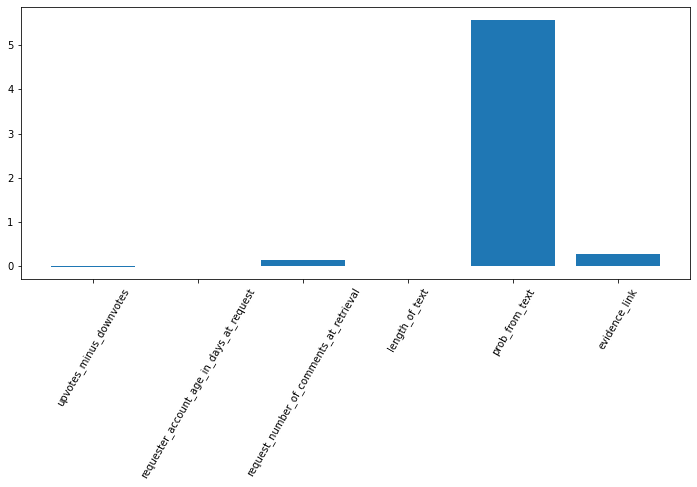

In [34]:
# get importance
# 0 -> upvotes_minus_downvotes
# 1 -> requester_account_age_in_days_at_request
# 2 -> request_number_of_comments_at_retrieval
# 3 -> length_of_text
# 4 -> prob_from_text
# 5 -> evidence_link

importance = final_model.coef_[0]

print(importance)

plt.figure(figsize = (12,5))
plt.xticks(rotation=60)
plt.bar([x for x in l], importance)
plt.show()